In [179]:
from system import *
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
import numpy as np
import pandas as pd
import random
import math
from tqdm import tqdm

In [169]:
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, transition):
        self.memory.append(transition)
        if len(self.memory) > self.capacity:
            del self.memory[0]

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [170]:
sns.set()

In [171]:
STATE_DIM = len(TradingEnv().reset())
#     print(f"STATE_DIM = {STATE_DIM}")
EMBED_DIM = 50  # from the dimensionality-reduced fastText model
HIDDEN_LAYER = 70  # NN hidden layer size
ACTION_DIM = 3

# EPISODES = 2000  # number of episodes
# EPS_START = 0.9  # e-greedy threshold start value
# EPS_END = 0.05  # e-greedy threshold end value
# EPS_DECAY = 200  # e-greedy threshold decay
# # GAMMA = 0.99  # Q-learning discount factor
# LR = 0.001  # NN optimizer learning rate
# HIDDEN_LAYER = 128  # NN hidden layer size
# BATCH_SIZE = 16  # Q-learning batch size
# TARGET_UPDATE = 100  # frequency of target update
# BUFFER_SIZE = 100  # capacity of the replay buffer

# if gpu is to be used
# use_cuda = torch.cuda.is_available()
use_cuda = False
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor


if use_cuda:
    print("GPU found and in use")
else:
    print("No GPU will be used")


class QNetwork(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(STATE_DIM, HIDDEN_LAYER)
        self.l2 = nn.Linear(HIDDEN_LAYER, HIDDEN_LAYER)
        self.l3 = nn.Linear(HIDDEN_LAYER, ACTION_DIM)

    def forward(self, x):
        """
            Computes the estimated Q-values for a given batch x
        """
        assert not torch.isnan(x).any(), f"NaN in input {x}"
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.l3(x)
        return x

    def sample_from_softmax_policy(self, batch_state):
        batch_q_values = self.forward(batch_state)
        batch_pi = F.softmax(batch_q_values, dim=1)
        batch_size = batch_pi.shape[0]
        batch_actions = torch.empty(batch_size, 1)
        for i in range(batch_size):
            pi = batch_pi[i, :]
            dist = torch.distributions.Categorical(pi)
            # Subtract 1, so batch_actions is in {-1, 0, 1}
            batch_actions[i, 0] = dist.sample().view(1, 1) - 1
        if use_cuda:
            batch_actions = batch_actions.to(batch_state.get_device())
        return batch_actions.long()


class BaseAgent:
#     EPISODES = 2000  # number of episodes
    
    LR = 0.001  # NN optimizer learning rate
    
    BATCH_SIZE = 16  # Q-learning batch size
    TARGET_UPDATE = 100  # frequency of target update
    BUFFER_SIZE = 100  # capacity of the replay buffer

    def __init__(self, gamma=0.9999):
        assert 0 < gamma < 1, f"Invalid gamma: {gamma}"
        sns.set()
        self.gamma = gamma
        self.memory = ReplayMemory(self.BUFFER_SIZE)
        self.history = pd.DataFrame()
#         self.rewards_history = []
        self.name = ""
        self.steps_done = 0
        with open("filtered_tickers.txt", "r") as src:
            self.filtered_tickers = src.read().split("\n")

    def run_episode(self, environment):
        """
            Takes an env, and trains the agent until the environment
            reaches a terminal state (ie the training window is complete).
            Must return environment.close()
        """
        raise NotImplementedError()

    def plot_cumulative_discounted_rewards(self):
        rl_data = self.history
        rl_data["discount_factor"] = np.power(self.gamma, rl_data.episode - 1)
        rl_data["discounted_future_reward"] = (
            rl_data["discount_factor"] * rl_data["rewards"]
        )
        rl_data = rl_data[["episode", "discounted_future_reward"]]
        rl_data = rl_data.groupby("episode").sum()
        #         rl_plot = sns.lineplot(data=rl_data, legend=False)
        title = "Cumulative Discounted Rewards over Episodes"
        if len(self.name):
            title = f'Cumulative Discounted Reward for {self.name}'
            
        rl_data.plot(legend=False, title=title)
        plt.ylabel("Cumulative Discounted Reward")
        if len(self.name):
            filename = f'plots/rewards-{self.name}.png'
            plt.savefig(filename)
        plt.show()

    def convert_action(self, action):
        assert action in [0,1,2], f'Invalid action: {action}'
        position = action - 1
        #         assert position in [-1,0,1]
        return position.item()

    def train(self, env_mode="train", num_tickers=20, num_episodes=5):
        """
            Trains the agent for num_episodes episodes, looping over the approved
            list of tickers (filtered by num_tickers). This is a convenience function.
        """
        num_tickers = min(num_tickers, len(self.filtered_tickers))
        if num_tickers == np.Inf:
            num_tickers = len(self.filtered_tickers)
        self.history = pd.DataFrame()
        for i in tqdm(range(num_episodes)):
            ticker = self.filtered_tickers[i % num_tickers]
            env = TradingEnv(ticker=ticker, mode=env_mode)
            history = self.run_episode(env)
            history["ticker"] = ticker
            history["episode"] = i + 1
            self.history = pd.concat((self.history, history))
        self.history = self.history.reset_index("Date", drop=True)
#         self.plot_returns(num_tickers)
#         self.plot_cumulative_discounted_rewards()

    def plot_returns(self, ticker):
        h = self.history
        roi_data = h[h.ticker == ticker][["date", "episode", "returns"]]
        plt.title(f"Returns for {ticker}")
        roi_plot = sns.lineplot(data=h, x="date", y="returns", hue="episode")
        roi_plot.set_xticklabels(roi_plot.get_xticklabels(), rotation=45)


No GPU will be used


In [172]:
class DQN(BaseAgent):
    EPS_START = 0.999  # e-greedy threshold start value
    EPS_END = 0.05  # e-greedy threshold end value
    EPS_DECAY = 200  # e-greedy threshold decay
    LR = 0.001  # NN optimizer learning rate

    def __init__(self):
        super().__init__()
        self.gamma = 0.9999
        self.model = QNetwork()
        self.target = QNetwork()
        if use_cuda:
            self.model.cuda()
            self.target.cuda()
        self.name = "Deep Q-Network"
        self.optimizer = optim.SGD(self.model.parameters(), self.LR)

    def select_epsilon_greedy_action(self, state):
        sample = random.random()
        eps_threshold = self.EPS_END + (self.EPS_START - self.EPS_END) * math.exp(
            -1.0 * self.steps_done / self.EPS_DECAY
        )
        self.steps_done += 1
        greedy_action = None
        with torch.no_grad():
            greedy_action = self.model(state).data.argmax(dim=1).view(1, 1)

        random_action = LongTensor([[random.randrange(ACTION_DIM)]])
        assert (
            greedy_action.shape == random_action.shape
        ), f"Incorrect sampling techinque {greedy_action.shape, random_action.shape}"
        if sample > eps_threshold:
            return greedy_action
        else:
            return random_action

    def run_episode(self, environment):
        state = environment.reset()
        steps = 0
        action = None
        while True:
            state_tensor = FloatTensor([state])
            action = self.select_epsilon_greedy_action(state_tensor)
            position = self.convert_action(action)
            next_state, reward, done, _ = environment.step(position)

            self.memory.push(
                (
                    FloatTensor([state]),
                    action,  # action is already a tensor
                    FloatTensor([next_state]),
                    FloatTensor([reward]),
                    FloatTensor([int(done)]),
                )
            )

            self.learn()
            if self.steps_done % self.TARGET_UPDATE == 0:
                self.target.load_state_dict(self.model.state_dict())

            state = next_state
            steps += 1
            if done:
                break
        history = environment.close()
        return history

    def max_next_q_values(self, batch_next_state):
        # expected Q values are estimated from actions which gives maximum Q value
        return self.target(batch_next_state).detach().max(1)[0]

    def learn(self):
        if len(self.memory) <= self.BATCH_SIZE:
            return
        # random transition batch is taken from experience replay memory
        transitions = self.memory.sample(self.BATCH_SIZE)
        batch_state, batch_action, batch_next_state, batch_reward, batch_done = zip(
            *transitions
        )
        batch_state = Variable(torch.cat(batch_state))
        batch_action = Variable(torch.cat(batch_action))
        batch_reward = Variable(torch.cat(batch_reward))
        batch_next_state = Variable(torch.cat(batch_next_state))
        batch_done = Variable(torch.cat(batch_done))

        # current Q values are estimated by NN for all actions
        current_q_values = self.model(batch_state).gather(1, batch_action).squeeze()
        expected_future_rewards = self.max_next_q_values(batch_next_state)

        expected_q_values = batch_reward + (self.gamma * expected_future_rewards) * (
            1 - batch_done
        )

        # loss is measured from error between current and newly expected Q values
        loss = F.smooth_l1_loss(current_q_values, expected_q_values)

        # backpropagation of loss to QNetwork
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


In [271]:
dqn_agent = DQN()
# e = TradingEnv('AMZN')
# dqn_agent.run_episode(e)
dqn_agent.train(env_mode='train', num_episodes=428)
# dqn_agent.train(num_tickers=len(dqn_agent.filtered_tickers), 
#                 num_episodes=len(dqn_agent.filtered_tickers) * 1)

100%|██████████| 428/428 [09:53<00:00,  1.39s/it]


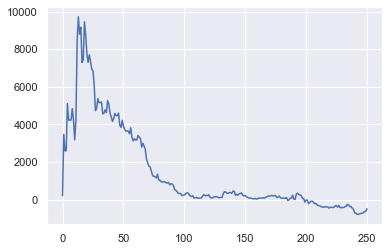

In [115]:
h = dqn_agent.history
h[h.episode == 1]['returns'].plot()

100%|██████████| 30/30 [00:43<00:00,  1.43s/it]


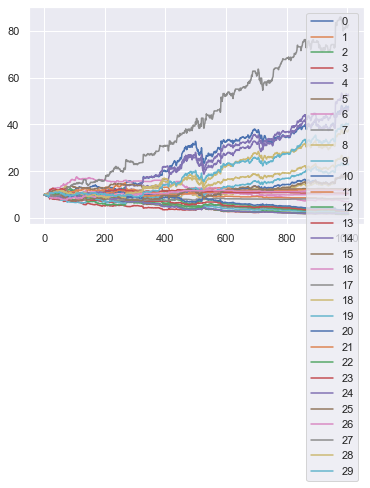

In [263]:
# n_trials = 30
# value_matrix = np.zeros((n_trials, 1005))
# from system import TradingEnv

# for i in tqdm(range(n_trials)):
#     dqn_agent = DQN()

#     e = TradingEnv('AMZN', target_volatility=0.1, mode='train')
# #     e.INITIAL_BALANCE = 1
# #     e.TRANSACTION_COST = 0.1
#     h = dqn_agent.run_episode(e)
#     net_values = [v - c for v,c in zip(e.values, e.cumulative_costs)]
#     value_matrix[i, :] = net_values
# #     plt.yscale('log')
#     plt.plot(net_values, label=i)
# #     plt.plot(h.returns)
# plt.legend()

In [270]:
e.data

,x,diff_x,std,sharpe,q
Date,,,,,
2013-11-08,0.000000,-0.500000,NaN,0.000000,0.000000
2013-11-11,0.500000,0.660824,NaN,0.000000,0.092601
2013-11-12,-0.160824,-0.740047,NaN,0.000000,0.052347
2013-11-13,0.579223,-0.149372,NaN,0.000000,0.067331
2013-11-14,0.728595,0.022383,NaN,0.000000,0.092004
...,...,...,...,...,...
2017-12-28,0.676475,0.018853,0.008582,0.065464,0.001219
2017-12-29,0.657623,-0.020740,0.010091,0.151089,-0.000671
2018-01-02,0.678362,-0.009618,0.010229,0.278552,-0.001257


(array([16.,  8.,  0.,  2.,  1.,  2.,  0.,  0.,  0.,  1.]),
 array([ 0.47861811,  2.72662716,  4.9746362 ,  7.22264525,  9.4706543 ,
        11.71866334, 13.96667239, 16.21468143, 18.46269048, 20.71069953,
        22.95870857]),
 <a list of 10 Patch objects>)

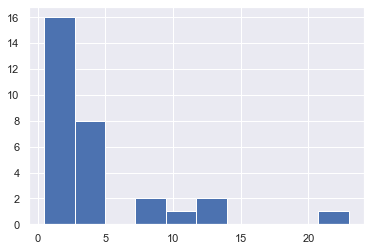

In [264]:
plt.hist(np.std(value_matrix, axis=1))

In [266]:
np.median(value_matrix[:, 1004] - e.INITIAL_BALANCE)

1.1407000996842234

(array([13.,  6.,  5.,  0.,  2.,  2.,  1.,  0.,  0.,  1.]),
 array([-8.4161193 , -0.32568843,  7.76474245, 15.85517332, 23.94560419,
        32.03603506, 40.12646593, 48.2168968 , 56.30732767, 64.39775854,
        72.48818942]),
 <a list of 10 Patch objects>)

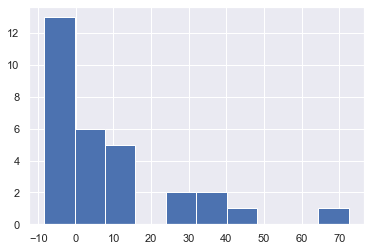

In [268]:
plt.hist(value_matrix[:, 1004] - e.INITIAL_BALANCE)
# plt.plot()

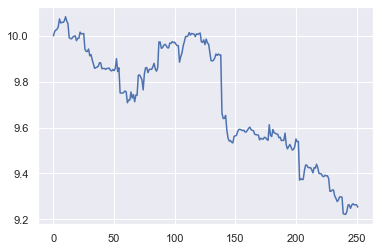

In [238]:
plt.plot(value_matrix.mean(axis=0))

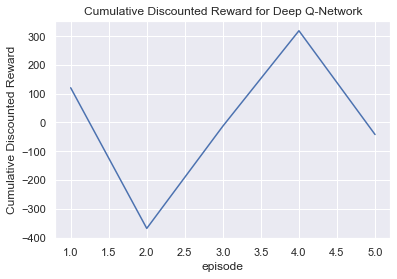

In [75]:
dqn_agent.plot_cumulative_discounted_rewards()

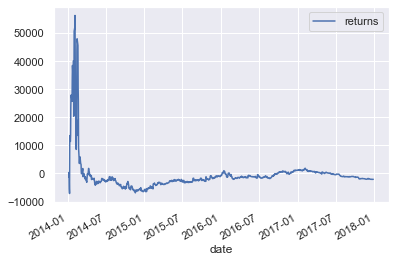

In [69]:
dqn_history = dqn_agent.history
dqn_history[dqn_history.episode == 400].plot('date', 'returns')

/home/aaruran/miniconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


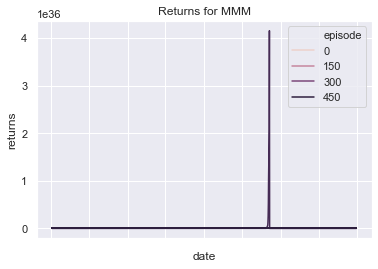

In [35]:
# plt.ylim(-1000,1000)
# dqn_agent.plot_returns('MMM')

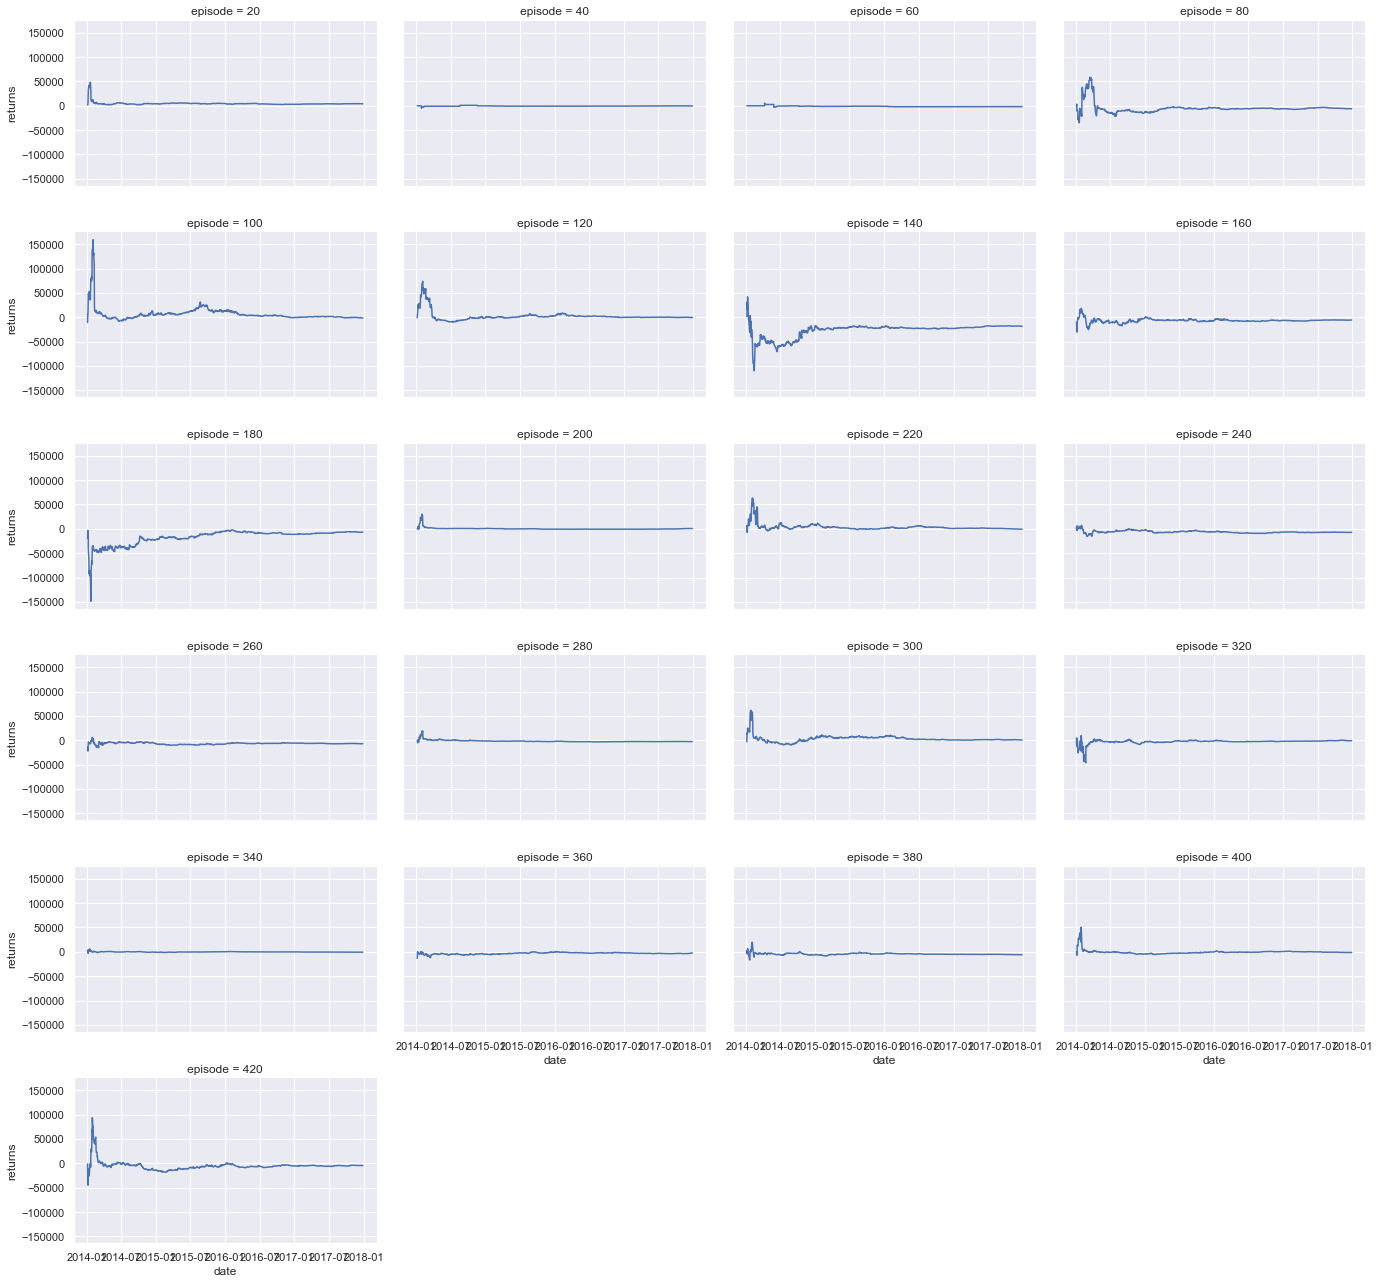

In [45]:
q = sns.FacetGrid(dqn_history[dqn_history.episode % 20 == 0], col='episode', col_wrap=4, aspect=1.61)
q.map(sns.lineplot, 'date', 'returns')

# LongOnly Agent

In [19]:
class LongOnlyAgent(BaseAgent):
    def __init__(self):
        super().__init__()
        self.name = "Long-Only Strategy"

    def run_episode(self, environment):
        state = environment.reset()
        steps = 0
        position = 1
        while True:
            _, r, done, __ = environment.step(position)
            self.steps_done += 1
            steps += 1
            if done:
                break
        self.history.append(environment.rewards_list)
        return environment.close()


In [20]:
long_agent = LongOnlyAgent()

In [23]:
long_agent.train(num_tickers=len(long_agent.filtered_tickers), 
                num_episodes=len(long_agent.filtered_tickers) * 1)

100%|██████████| 429/429 [07:01<00:00,  1.02it/s]


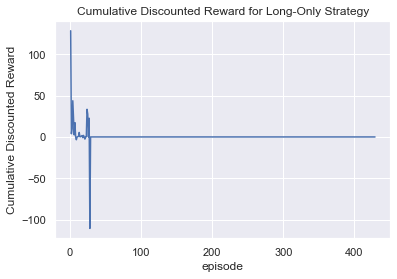

In [24]:
long_agent.plot_cumulative_discounted_rewards()

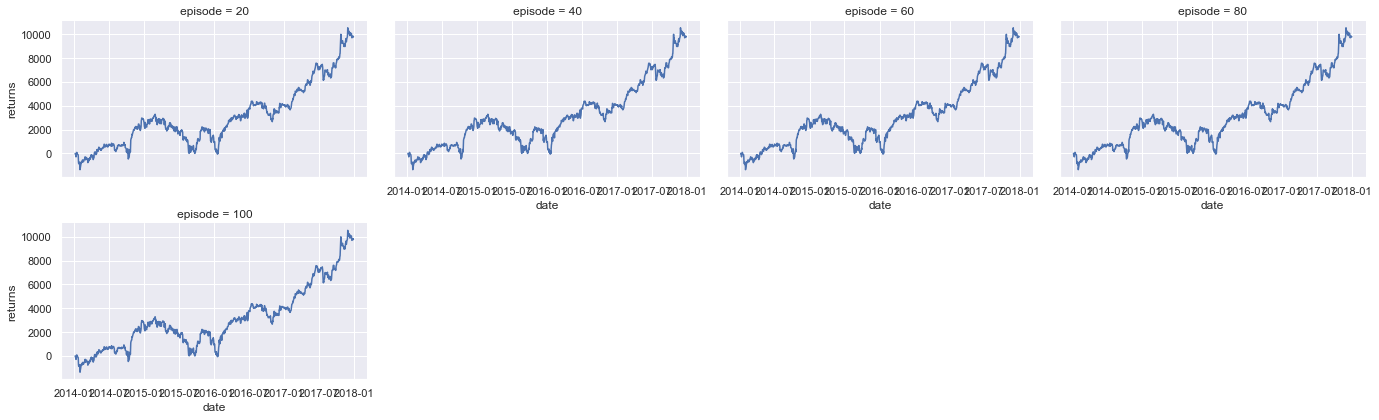

In [21]:
q = sns.FacetGrid(long_agent.history[long_agent.history.episode % 20 == 0], col='episode', col_wrap=4, aspect=1.61)
q.map(sns.lineplot, 'date', 'returns')

# Policy Network

In [31]:
class PolicyNetwork(nn.Module):
    # for Policy-Gradient methods, e.g. actor-only and actor-critic methods
    def __init__(self):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(STATE_DIM, HIDDEN_LAYER)
        self.l2 = nn.Linear(HIDDEN_LAYER, HIDDEN_LAYER)
        self.l3 = nn.Linear(HIDDEN_LAYER, ACTION_DIM)

    def forward(self, x, logits=True):
        """
            returns the logits of the probability
        """
        assert not torch.isnan(x).any(), f"NaN in input {x}"
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.l3(x)
        if not logits:
            x = torch.softmax(x, dim=1)
        return x

    def sample_from_softmax_policy(self, batch_state):
        batch_logits = self.forward(batch_state).detach()
        assert not torch.isnan(batch_logits).any(), f"NaN in policy logits {batch_logits}"
        batch_size = batch_logits.shape[0]
        actions = torch.empty(batch_size, 1)
        for i in range(batch_size):
            logits = batch_logits[i, :]
            dist = torch.distributions.Categorical(logits=logits)
            actions[i, 0] = dist.sample().view(1, 1)
        if use_cuda:
            actions = actions.to(batch_state.get_device())
        return actions.long()

# A2C

In [97]:
class A2C(BaseAgent):
    def __init__(self):
        super().__init__()
        self.name = "A2C"
        self.policy = PolicyNetwork()
        self.model = QNetwork()
        if use_cuda:
            self.policy.cuda()
            self.model.cuda()

        self.optimizer = optim.Adam(
            chain(self.model.parameters(), self.policy.parameters()), self.LR
        )

    def run_episode(self, environment):
        state = environment.reset()
        self.steps_done = 0
        action = None
        while True:
            state_tensor = FloatTensor([state])
            action = self.policy.sample_from_softmax_policy(state_tensor)
            position = self.convert_action(action)
            next_state, reward, done, _ = environment.step(position)
            next_state_tensor = FloatTensor([next_state])
            self.learn(state_tensor, action, next_state_tensor, reward)
            state = next_state
            self.steps_done += 1
            if done:
                break
        history = environment.close()
        return history

    def learn(self, state_tensor, action, next_state_tensor, reward):
        n = self.steps_done

        expected_q = reward + self.gamma * self.model(next_state_tensor).max(dim=1)[0]
        q_values = self.model(state_tensor)
        current_q = q_values.gather(1, action).squeeze(0)
#         assert current_q.shape == expected_q.shape, f"Wrong shapes for q-values {current_q.shape, expected_q.shape}"
        q_loss = F.smooth_l1_loss(current_q, expected_q.detach())
        
        pi = self.policy(state_tensor, logits=False)
        A = expected_q - torch.dot(q_values.squeeze(0), pi.squeeze(0))
        pi_a = pi.gather(1, action)
        policy_loss = -A.detach() * torch.log(pi_a)

        loss = (self.gamma ** n) * (policy_loss + q_loss)

        # backpropagation of loss to QNetwork and PolicyNetwork
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


In [98]:
a2c_agent = A2C()
a2c_agent.train(num_tickers=len(a2c_agent.filtered_tickers),
                num_episodes=len(a2c_agent.filtered_tickers))

100%|██████████| 429/429 [12:55<00:00,  1.81s/it]


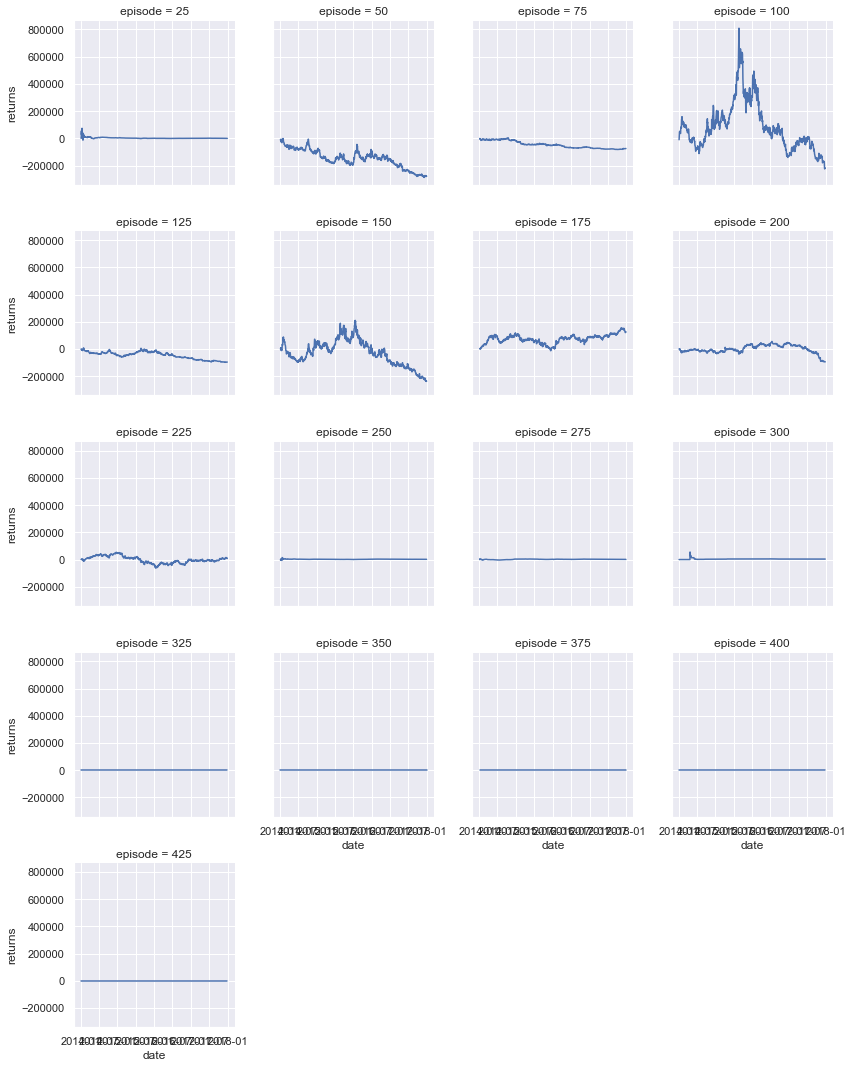

In [99]:
h = a2c_agent.history
q = sns.FacetGrid(h[h.episode % 25 == 0], col='episode',col_wrap=4)
q.map(sns.lineplot, 'date', 'returns')

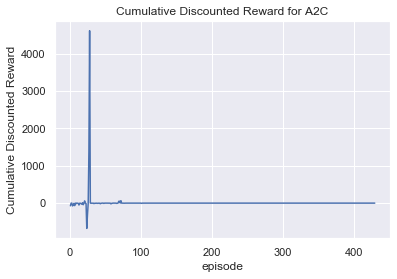

In [100]:
a2c_agent.plot_cumulative_discounted_rewards()

In [108]:
a2c_agent.history

,date,ticker,rewards,actions,returns,prices,episode,discount_factor,discounted_future_reward
0,2014-01-06,MMM,0.011218,1,199.890137,137.630005,1,1.000000e+00,0.011218
1,2014-01-07,MMM,0.905464,-1,3466.593424,137.649994,1,1.000000e+00,0.905464
2,2014-01-08,MMM,0.260848,-1,4075.578672,136.630005,1,1.000000e+00,0.260848
3,2014-01-09,MMM,-0.428486,1,1882.570206,136.449997,1,1.000000e+00,-0.428486
4,2014-01-10,MMM,-2.281514,1,-1148.903435,136.179993,1,1.000000e+00,-2.281514
...,...,...,...,...,...,...,...,...,...
430623,2017-12-21,ZTS,-0.000000,0,0.000000,72.279999,429,2.922154e-10,-0.000000
430624,2017-12-22,ZTS,0.000000,0,0.000000,71.989998,429,2.922154e-10,0.000000
430625,2017-12-26,ZTS,0.000000,0,0.000000,72.339996,429,2.922154e-10,0.000000
430626,2017-12-27,ZTS,-0.000000,0,0.000000,72.449997,429,2.922154e-10,-0.000000


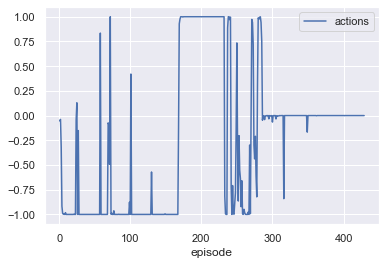

In [109]:
a2c_agent.history[['episode', 'actions']].groupby('episode').mean().plot()

# DDPG

In [76]:
class DeterministicPolicyNetwork(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(STATE_DIM, HIDDEN_LAYER)
        self.l2 = nn.Linear(HIDDEN_LAYER, HIDDEN_LAYER)
        self.l3 = nn.Linear(HIDDEN_LAYER, 1)

    def forward(self, x):
        """
            returns the position (in [-1, 1])
        """
        assert not torch.isnan(x).any(), f"NaN in input {x}"
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.l3(x)
        return torch.clamp(x, -1, 1)

In [77]:
class DeterministicQNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1_s = nn.Linear(STATE_DIM, HIDDEN_LAYER)
        self.l1_p = nn.Linear(1, HIDDEN_LAYER)
        self.l2 = nn.Linear(2 * HIDDEN_LAYER, 2 * HIDDEN_LAYER)
        self.l3 = nn.Linear(2 * HIDDEN_LAYER, 1)
        
    def forward(self, s, p):
        """
            maps (state, position) to a q-value
        """
        h1 = F.relu(self.l1_s(s))
        h2 = F.relu(self.l1_p(p))
        cat = torch.cat([h1, h2], dim=1)
        q = F.relu(self.l2(cat))
        q = self.l3(q)
        return q

In [308]:
class DDPG(BaseAgent):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.name = "DDPG"
        self.policy = DeterministicPolicyNetwork()
        self.policy_opt = optim.Adam(self.policy.parameters())
        
        self.model = DeterministicQNetwork()
        self.model_opt = optim.Adam(self.model.parameters())
        
    def run_episode(self, environment):
        state = environment.reset()
        self.steps_done = 0
        while True:
            state_tensor = FloatTensor([state])
            assert not torch.isnan(state_tensor).any()
            posn = self.policy(state_tensor)
            next_state, reward, done, _ = environment.step(posn.item())
            next_state_tensor = FloatTensor([next_state])
            self.learn(state_tensor, posn, next_state_tensor, reward)
            state = next_state
            self.steps_done += 1
            if done:
                break
        history = environment.close()
        return history
    
    def learn(self, state_tensor, posn, next_state_tensor, reward):
        n = self.steps_done
        next_posn = self.policy(next_state_tensor)
        expected_q = reward + self.gamma * self.model(next_state_tensor, next_posn)
        q_values = self.model(state_tensor, posn)
        current_q = q_values

        q_loss = F.smooth_l1_loss(current_q, expected_q.detach()) * (self.gamma ** n)
        
        self.model_opt.zero_grad()
        q_loss.backward()
        self.model_opt.step()
        
        suggested_posn = self.policy(state_tensor)
        policy_loss = -self.model(state_tensor, suggested_posn) * (self.gamma ** n)
        
        self.policy_opt.zero_grad()
        policy_loss.backward()
        self.policy_opt.step()
        
        
    def train(self, env_mode="train", num_tickers=20, num_episodes=5, **kwargs):
        """
            Trains the agent for num_episodes episodes, looping over the approved
            list of tickers (filtered by num_tickers). This is a convenience function.
        """
        num_tickers = min(num_tickers, len(self.filtered_tickers))
        if num_tickers == np.Inf:
            num_tickers = len(self.filtered_tickers)
        self.history = pd.DataFrame()
        for i in tqdm(range(num_episodes)):
            ticker = self.filtered_tickers[i % num_tickers]
            env = ContinuousTradingEnv(ticker=ticker, **kwargs)
            history = self.run_episode(env)
            history["ticker"] = ticker
            history["episode"] = i + 1
            self.history = pd.concat((self.history, history))
        self.history = self.history.reset_index("Date", drop=True)

In [323]:
ddpg_agent = DDPG()
ddpg_agent.train(num_tickers=9, num_episodes=27)
# ddpg_agent.train(num_tickers=len(ddpg_agent.filtered_tickers),
#                  num_episodes=len(ddpg_agent.filtered_tickers))

100%|██████████| 27/27 [01:00<00:00,  2.23s/it]


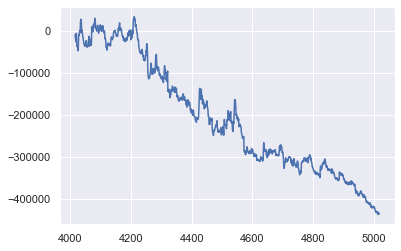

In [325]:
h = ddpg_agent.history
h[h.episode == 5]['returns'].plot()
# h[h.episode == 1]

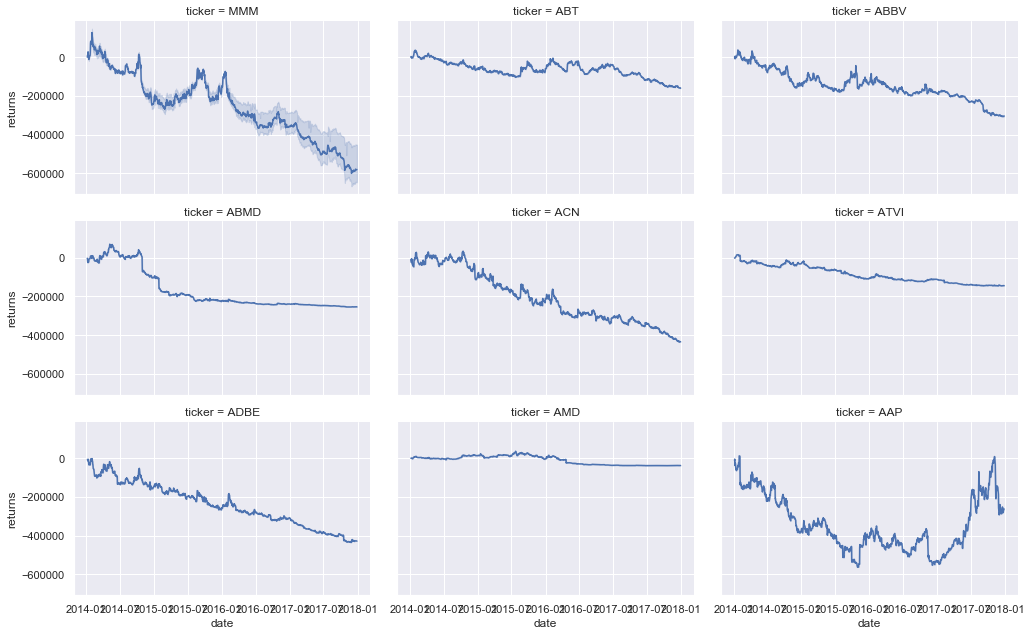

In [324]:
q = sns.FacetGrid(ddpg_agent.history, col='ticker', col_wrap=3, aspect=1.61)
q.map(sns.lineplot, 'date', 'returns')

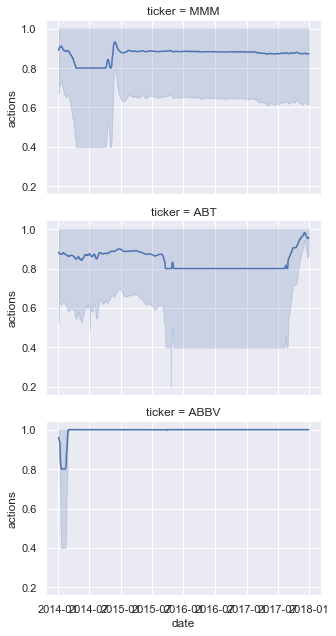

In [317]:
q = sns.FacetGrid(ddpg_agent.history, row='ticker', aspect=1.61)
q.map(sns.lineplot, 'date', 'actions')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f501d23c750>],
      dtype=object)

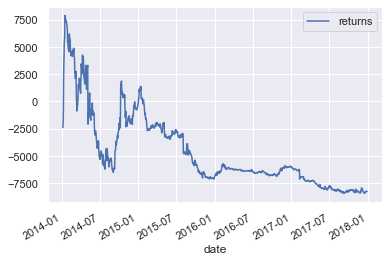

In [296]:
h[h.episode == 6].plot(x='date', y='returns', subplots=True)

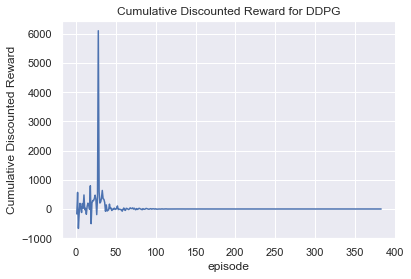

In [85]:
ddpg_agent.plot_cumulative_discounted_rewards()

In [46]:
ddpg_agent.history.tail(10)

,date,ticker,rewards,actions,returns,prices,episode,discount_factor,discounted_future_reward
Date,,,,,,,,,
2017-12-14,2017-12-14,TSCO,-48.638628,-1.0,4824.383355,66.779999,383,3.093266e-09,-1.504522e-07
2017-12-15,2017-12-15,TSCO,-28.920339,-1.0,4664.174877,68.419998,383,3.093266e-09,-8.945829e-08
2017-12-18,2017-12-18,TSCO,-49.614682,-1.0,4403.179110,69.199997,383,3.093266e-09,-1.534714e-07
2017-12-19,2017-12-19,TSCO,-84.376265,-1.0,3925.576294,70.500000,383,3.093266e-09,-2.609982e-07
2017-12-20,2017-12-20,TSCO,-47.362934,-1.0,3669.591833,72.970001,383,3.093266e-09,-1.465061e-07
2017-12-21,2017-12-21,TSCO,-3.009030,-1.0,3653.986157,74.389999,383,3.093266e-09,-9.307729e-09
2017-12-22,2017-12-22,TSCO,-27.235636,-1.0,3512.151060,74.480003,383,3.093266e-09,-8.424706e-08
2017-12-26,2017-12-26,TSCO,16.013655,-1.0,3583.217089,75.300003,383,3.093266e-09,4.953449e-08
2017-12-27,2017-12-27,TSCO,-7.980451,-1.0,3548.996180,74.879997,383,3.093266e-09,-2.468566e-08


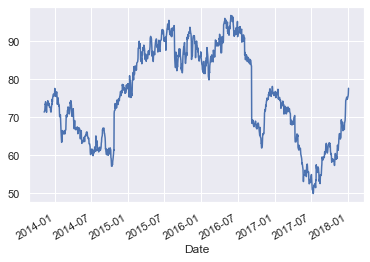

In [50]:
e = ContinuousTradingEnv('TSCO')
e.prices.plot()

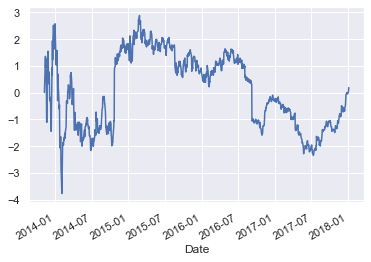

In [51]:
e.prices_normalized.plot()

 # Model-based (using Reddit Comments)

In [ ]:
class ModelBasedAgent(BaseAgent):
    def __init__(self):
        super().__init__()